### Ridge Regression Demand Forecasting Project

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# === 1. Load dataset ===
df = pd.read_csv("sales_data.csv")

# === 2. Convert Date ===
df['Date'] = pd.to_datetime(df['Date'])

#### Unique Time Series Identification

Each time series is uniquely identified by a combination of **Store ID** and **Product ID**.

This is necessary because the dataset includes multiple products across multiple stores, as shown below:

| Store ID | Product ID |
|----------|------------|
| S001     | P0001      |
| S001     | P0002      |
| S002     | P0001      |
| S002     | P0002      |

Each row represents a distinct product-store combination, which forms a separate time series.

In [24]:
# === 3. Create composite ID ===
df['Store_Product_ID'] = df['Store ID'].astype(str) + '_' + df['Product ID'].astype(str)

#### Ensures lag and rolling computations are applied in time order within each product-store.

In [25]:
# === 4. Sort for lag features ===
df = df.sort_values(by=['Store_Product_ID', 'Date'])

#### Creates historical features (lags) and 7-day/14-day rolling averages to capture trends and seasonality.

In [26]:
# === 5. Lag and rolling features ===
df['Lag_1_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1)
df['Lag_2_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(2)
df['Lag_3_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(3)
df['Rolling_7_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1).rolling(window=7).mean()
df['Rolling_14_Demand'] = df.groupby('Store_Product_ID')['Demand'].shift(1).rolling(window=14).mean()

#### Binary features that help the model learn from supply-demand imbalances.

In [27]:
# === 6. Backorder and stockout risk ===
df['Backorder'] = (df['Units Ordered'] > df['Units Sold']).astype(int)
df['Stockout_Risk'] = (df['Inventory Level'] < df['Units Ordered']).astype(int)

#### Extracts time-based signals, including cyclical patterns like seasonal sinusoids for DayOfYear.

In [28]:
# === 7. Date features + seasonality ===
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df['Quarter'] = df['Date'].dt.quarter
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Is_Weekend'] = df['Weekday'].isin([5, 6]).astype(int)
df['Sin_DayOfYear'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
df['Cos_DayOfYear'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)

#### Transforms regions, weather, category, and seasonality into numeric columns the model can use.

In [29]:
# === 8. Encode categoricals ===
# Save original region and category info before encoding (For Inventory Optimization)
df['Original_Region'] = df['Region']
df['Original_Category'] = df['Category']
df = pd.get_dummies(df, columns=['Region', 'Weather Condition', 'Seasonality', 'Category'], drop_first=True)

#### Combines features that interact logically

In [30]:
# === 9. Feature interactions ===
df['Price_Discount'] = df['Price'] * df['Discount']
df['Price_vs_Competitor'] = df['Price'] - df['Competitor Pricing']
df['Promo_Discount'] = df['Promotion'] * df['Discount']

#### Removes rows with missing values after lagging and rolling.

In [31]:
# === 10. Drop rows with NaNs ===
print(f"The number of rows before dropping rows with NaNs : {len(df)}")
df.dropna(inplace=True)
print(f"The number of rows after dropping rows with NaNs : {len(df)}")

The number of rows before dropping rows with NaNs : 76000
The number of rows after dropping rows with NaNs : 74600


#### Demand Standardization Within Each Time Series

This part of the code:

```python
df['Demand_scaled'] = df.groupby('Store_Product_ID')['Demand'].transform(
    lambda x: (x - x.mean()) / x.std()
)
```

is standardizing the demand within each `Store_Product_ID` group.

For each unique combination of store and product (e.g., `"S001_P0001"`), it applies the following transformation to the `Demand` values:

```
Demand_scaled = (Demand - mean) / std_deviation
```

Where:

- `m` is the **mean** demand for that `Store_Product_ID`
- `s` is the **standard deviation** of demand for that `Store_Product_ID`

---

##### Why This is Done

There are three key reasons for this standardization:

---

##### 1. Fair Comparison Across Groups

- Each `Store_Product_ID` can have very different sales volumes.
- A high-volume combination (e.g., `S001_P0001`) might have an average demand of 500, while a low-volume one (e.g., `S003_P0009`) might average 5.
- **Standardization ensures** the model learns **patterns**, not just magnitudes.

---

##### 2. Better Model Convergence

- Machine learning algorithms (especially those using gradient-based optimization like Ridge Regression) work better when features are on **similar scales**.
- Standardizing the target:
  - Helps the model converge **faster**
  - Prevents bias toward **large-valued outputs**

---

##### 3. Prevent Data Leakage

- Grouping by `Store_Product_ID` ensures that **no information leaks across different time series** (i.e., between store-product combinations).
- This is especially important in **time-series forecasting**.

---

##### Reversing the Standardization

Later, the standardized predictions are converted back to actual demand values:

```python
preds_df['y_pred'] = preds_df['y_pred_scaled'] * stdevs + means
```

- This transforms the model's predicted standardized demand (`y_pred_scaled`) back to actual demand units using the **group-specific mean and standard deviation**.

---

##### Summary

This line below

- Scales demand to **zero mean and unit variance** within each time series (`Store_Product_ID`)
- Stabilizes training and enables the model to learn **relative patterns** more effectively
- Then unscales predictions to retrieve the **actual demand numbers**

In [32]:
# === 11. Normalize demand by composite ID ===
df['Demand_scaled'] = df.groupby('Store_Product_ID')['Demand'].transform(
    lambda x: (x - x.mean()) / x.std()
)

#### Sets target (y) and predictors (X) for training.

In [33]:
# === 12. Set target and features ===
y = df['Demand_scaled']

feature_cols = [
    'Price', 'Discount', 'Competitor Pricing', 'Promotion', 'Inventory Level',
    'Units Ordered', 'Month', 'Day', 'Weekday', 'Quarter', 'DayOfYear', 'Is_Weekend',
    'Sin_DayOfYear', 'Cos_DayOfYear', 'Backorder', 'Stockout_Risk', 'Epidemic',
    'Lag_1_Demand', 'Lag_2_Demand', 'Lag_3_Demand', 'Rolling_7_Demand', 'Rolling_14_Demand',
    'Price_Discount', 'Price_vs_Competitor', 'Promo_Discount'
]

feature_cols += [col for col in df.columns if
                 col.startswith('Region_') or
                 col.startswith('Weather Condition_') or
                 col.startswith('Seasonality_') or
                 col.startswith('Category_')]

X = df[feature_cols]

#### TimeSeriesSplit

- This sets up time-aware cross-validation.
- Instead of randomly shuffling data, TimeSeriesSplit ensures that training data always precedes test data, which is crucial in time series forecasting.
- With n_splits=5, it creates 5 train/test splits that respect time order.

In [34]:
# === 13. TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=5)

#### RidgeCV Pipeline

1. ('poly', PolynomialFeatures(degree=2, include_bias=False))

- Expands your input features to include polynomial terms up to degree 2.
- If your features are [x1, x2], it adds terms like [x1², x2², x1*x2].
- include_bias=False avoids adding a column of ones.

2. ('scaler', StandardScaler())

- Standardizes features (zero mean, unit variance), which is important for regularized models like Ridge.

3. ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], scoring='r2', cv=tscv))

- Trains a Ridge Regression model.
- Uses cross-validation to find the best alpha (regularization strength) from the list [0.001, 0.01, 0.1, 1.0, 10.0].
- scoring='r2' means it selects the alpha that gives the best R² score.
- cv=tscv uses the TimeSeriesSplit defined earlier.

In [35]:
# === 14. RidgeCV Pipeline ===
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], scoring='r2', cv=tscv))
])

# === Trains the full pipeline with cross-validated Ridge regression.
pipeline.fit(X, y)

,steps,"[('poly', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,False
,order,'C'
,copy,True
,with_mean,True
,with_std,True


#### Gets predictions, then reverts them from scaled units back to actual demand values.

In [36]:
# === 15. Prediction ===
y_pred_scaled = pipeline.predict(X)

##### Inverse Scale Predictions
- `preds_df`: a new DataFrame to hold actual and predicted values.
- `means` and `stdevs`: calculated per `Store_Product_ID`, used to reverse standardization.
- `y_pred`: transforms `y_pred_scaled` back to original demand scale using:

$$
y_{pred} = y_{pred\_scaled} \times \sigma + \mu
$$

In [37]:
# === 16. Inverse scale back to original demand ===
preds_df = df[['Store_Product_ID', 'Demand', 'Date']].copy()
preds_df['y_pred_scaled'] = y_pred_scaled

means = df.groupby('Store_Product_ID')['Demand'].transform('mean')
stdevs = df.groupby('Store_Product_ID')['Demand'].transform('std')

preds_df['y_pred'] = preds_df['y_pred_scaled'] * stdevs + means

##### Add 95% Prediction Interval
- `residual_std`: standard deviation of the residuals (actual - predicted).
- Assumes residuals are normally distributed.
- Adds upper and lower bounds covering ~95% of expected variation:

$$
y_{upper} = y_{pred} + 1.96 \cdot \sigma
$$
$$
y_{lower} = y_{pred} - 1.96 \cdot \sigma
$$

In [38]:
# === Add 95% prediction interval ===
# === Uses standard deviation of residuals to create a confidence band (±1.96σ covers ~95%).
residual_std = (preds_df['Demand'] - preds_df['y_pred']).std()
preds_df['y_upper'] = preds_df['y_pred'] + 1.96 * residual_std
preds_df['y_lower'] = preds_df['y_pred'] - 1.96 * residual_std

#### Evaluation

In [39]:
# === 17. Evaluation ===
r2 = r2_score(preds_df['Demand'], preds_df['y_pred'])
mae = mean_absolute_error(preds_df['Demand'], preds_df['y_pred'])
rmse = np.sqrt(mean_squared_error(preds_df['Demand'], preds_df['y_pred']))
actual_std = preds_df['Demand'].std()

print(f"R² Score ( % variance explained ): {r2:.4f}")
print(f"MAE ( average absolute error ): {mae:.4f}")
print(f"RMSE ( error magnitude (in same units as demand) ): {rmse:.4f}")
print(f"Std Dev of Actual Demand: {actual_std:.4f}")
print(f"Std Dev of Residuals: {residual_std:.4f}")

R² Score ( % variance explained ): 0.6806
MAE ( average absolute error ): 20.2389
RMSE ( error magnitude (in same units as demand) ): 26.5680
Std Dev of Actual Demand: 47.0093
Std Dev of Residuals: 26.5682


#### Visual check for bias: residuals should be centered around 0 and evenly spread.

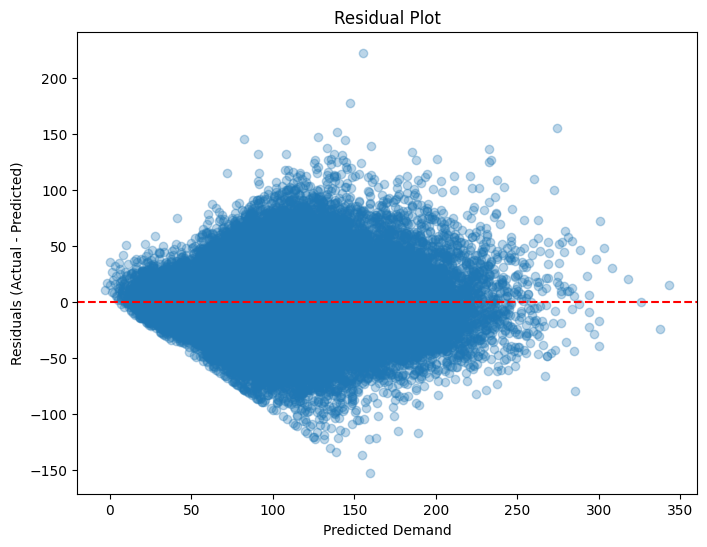

In [40]:
# === 18. Residual Plot ===
plt.figure(figsize=(8,6))
plt.scatter(preds_df['y_pred'], preds_df['Demand'] - preds_df['y_pred'], alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Demand")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

#### Actual vs Predicted Demand over time
#### Shaded area = 95% prediction interval

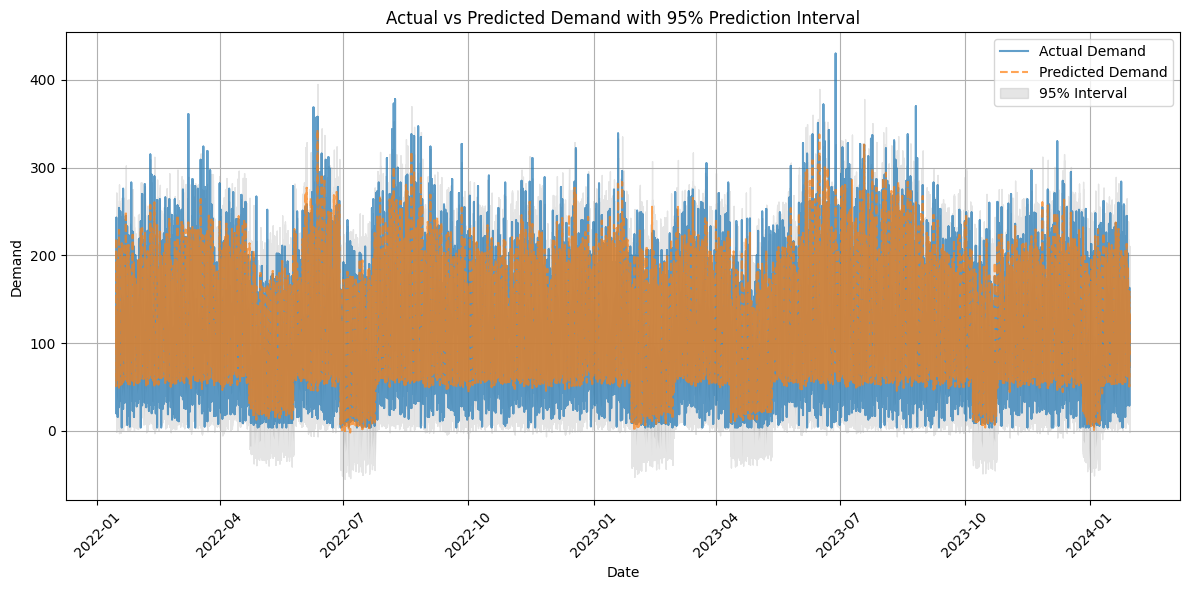

In [41]:
# === 19. Time Series Plot with Prediction Interval ===

preds_df = preds_df.sort_values('Date')

plt.figure(figsize=(12,6))
plt.plot(preds_df['Date'], preds_df['Demand'], label='Actual Demand', alpha=0.7)
plt.plot(preds_df['Date'], preds_df['y_pred'], label='Predicted Demand', linestyle='--', alpha=0.7)
plt.fill_between(preds_df['Date'], preds_df['y_lower'], preds_df['y_upper'], color='gray', alpha=0.2, label='95% Interval')
plt.title("Actual vs Predicted Demand with 95% Prediction Interval")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# === Summary for Presentation ===
summary = """
📊 MODEL SUMMARY
--------------------------
✅ Model Type: Ridge Regression (Linear)
✅ Forecast Target: Product Demand
✅ Features Used: Price, Inventory, Seasonality, Lags, Promotions, etc.
✅ Polynomial Degree: 2 (to capture feature interactions)
✅ Composite Key: Store ID + Product ID
✅ Normalization: Demand scaled per Product-Store
✅ Validation: TimeSeriesSplit Cross-Validation
✅ Forecast Output: Point estimate + 95% Prediction Interval

📈 METRICS
--------------------------
R² Score: {:.4f}
MAE: {:.2f}
RMSE: {:.2f}
Std Dev of Actual Demand: {:.2f}
Std Dev of Residuals: {:.2f}

💡 INSIGHT
--------------------------
Prediction intervals help estimate inventory risk.
Overestimating → Overstock costs
Underestimating → Stockouts & lost sales
""".format(r2, mae, rmse, actual_std, residual_std)

print(summary)



📊 MODEL SUMMARY
--------------------------
✅ Model Type: Ridge Regression (Linear)
✅ Forecast Target: Product Demand
✅ Features Used: Price, Inventory, Seasonality, Lags, Promotions, etc.
✅ Polynomial Degree: 2 (to capture feature interactions)
✅ Composite Key: Store ID + Product ID
✅ Normalization: Demand scaled per Product-Store
✅ Validation: TimeSeriesSplit Cross-Validation
✅ Forecast Output: Point estimate + 95% Prediction Interval

📈 METRICS
--------------------------
R² Score: 0.6806
MAE: 20.24
RMSE: 26.57
Std Dev of Actual Demand: 47.01
Std Dev of Residuals: 26.57

💡 INSIGHT
--------------------------
Prediction intervals help estimate inventory risk.
Overestimating → Overstock costs
Underestimating → Stockouts & lost sales



# Set Holding and Shortage Cost Percentages

Holding cost is calculated based on storage, capital, service and risk costs.

Shortage cost is calculated based on lost sales, customer dissatisfaction or churn, expedited shipping.

Unfortunately, we don't have all of information to calculate it from the Kaggle's dataset.

Then we research some articles to identify  some possible numbers to use in our project.

For Holding Cost: 25% / year
Reference: https://www.researchgate.net/publication/280529747_inventory_and_holding_costs

For Shortage Cost: around 20%
Reference: https://www.researchgate.net/publication/220534630_Measuring_and_Mitigating_the_Cost_of_Stockouts

In [44]:
# Merge back with original data to get Inventory Level and Price
cost_df = preds_df.merge(
    df[['Store_Product_ID', 'Date', 'Inventory Level', 'Price', 'Original_Category', 'Original_Region']],
    on=['Store_Product_ID', 'Date'],
    how='left'
)

# Calculate daily holding cost per unit
cost_df['Holding_Cost_per_Unit'] = (0.25 * cost_df['Price']) / 365

# Calculate holding cost (based on inventory held)
cost_df['Holding_Cost'] = cost_df['Inventory Level'] * cost_df['Holding_Cost_per_Unit']

# Calculate shortage (unmet demand)
cost_df['Shortage'] = np.maximum(cost_df['y_pred'] - cost_df['Inventory Level'], 0)

# Calculate shortage cost
cost_df['Shortage_Cost'] = cost_df['Shortage'] * 0.20 * cost_df['Price']


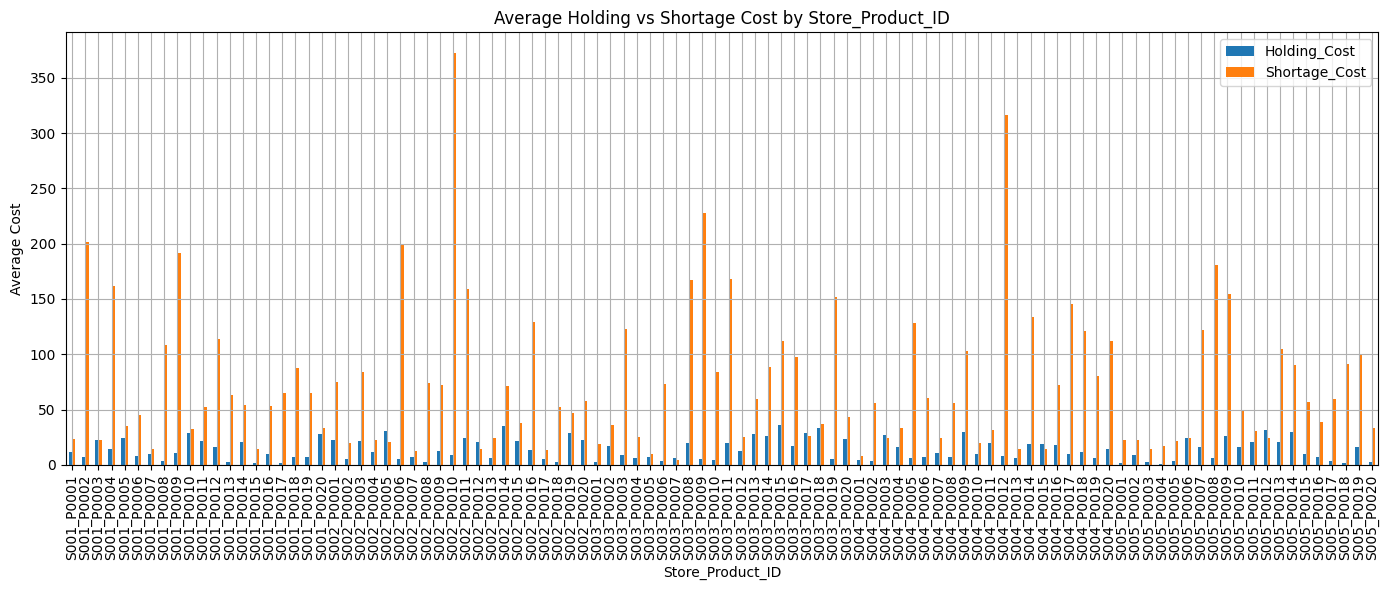

In [45]:
store_summary = cost_df.groupby('Store_Product_ID')[['Holding_Cost', 'Shortage_Cost']].mean().reset_index()

# Plot
store_summary.plot(kind='bar', x='Store_Product_ID', figsize=(14,6), stacked=False)
plt.ylabel('Average Cost')
plt.title('Average Holding vs Shortage Cost by Store_Product_ID')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


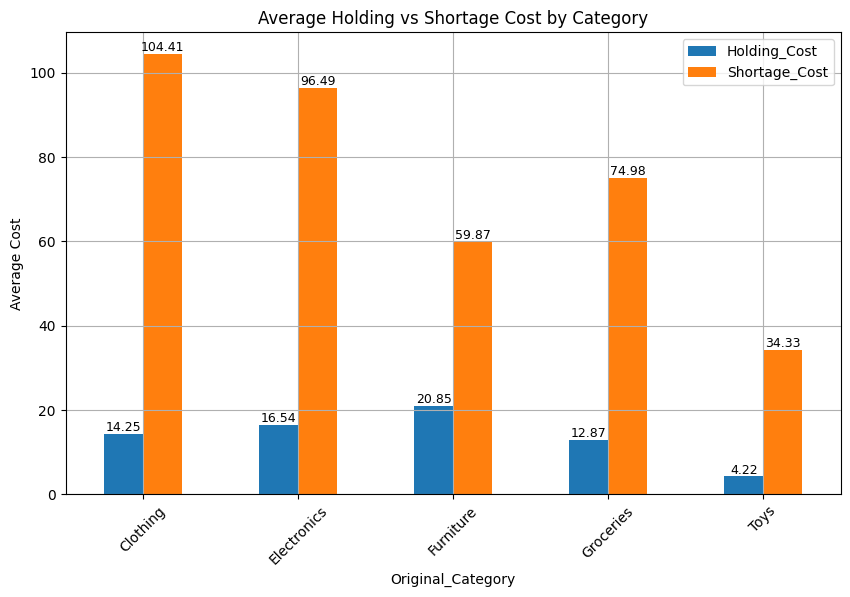

In [50]:
category_summary = cost_df.groupby('Original_Category')[['Holding_Cost', 'Shortage_Cost']].mean().reset_index()

ax = category_summary.plot(
    kind='bar',
    x='Original_Category',
    figsize=(10, 6),
    stacked=False,
    legend=True,
    ylabel='Average Cost',
    title='Average Holding vs Shortage Cost by Category',
    rot=45,
    grid=True
)

# Annotate each bar with its value
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

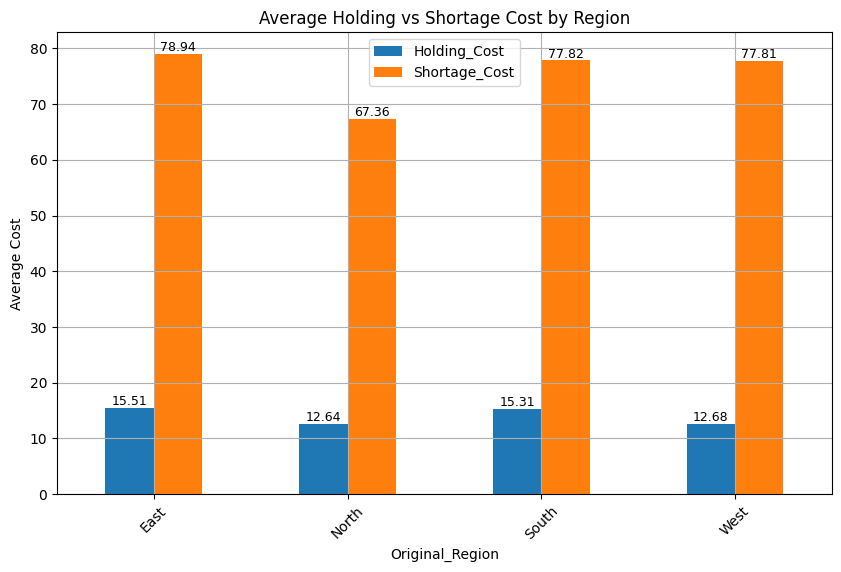

In [53]:
region_summary = cost_df.groupby('Original_Region')[['Holding_Cost', 'Shortage_Cost']].mean().reset_index()

ax = region_summary.plot(
    kind='bar',
    x='Original_Region',
    figsize=(10, 6),
    stacked=False,
    legend=True,
    ylabel='Average Cost',
    title='Average Holding vs Shortage Cost by Region',
    rot=45,
    grid=True
)

# Annotate each bar with its value
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

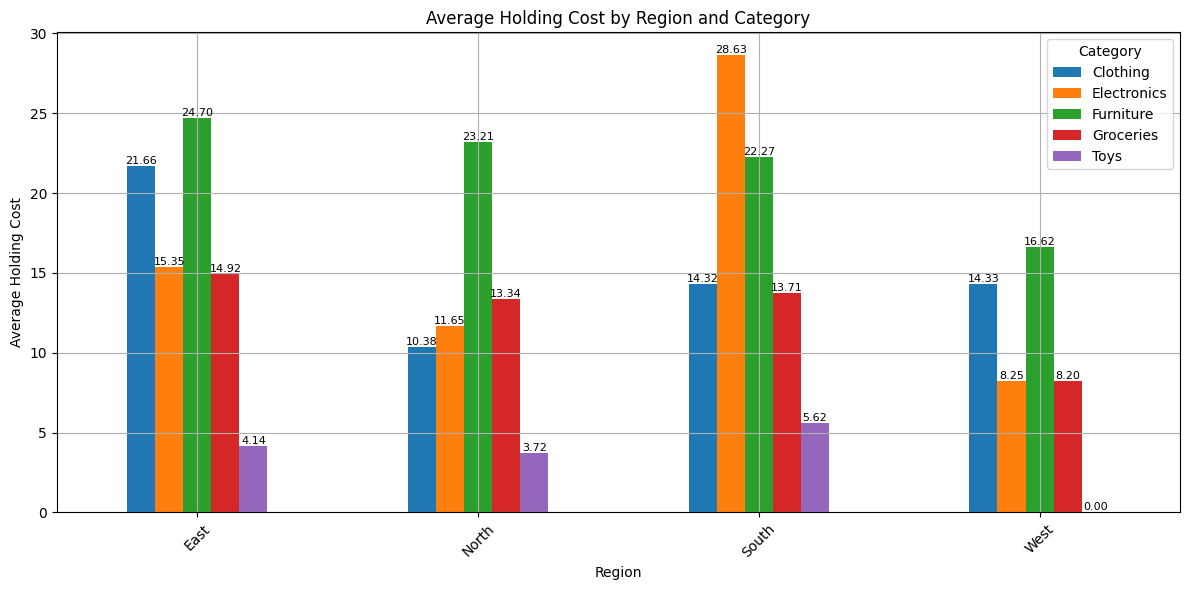

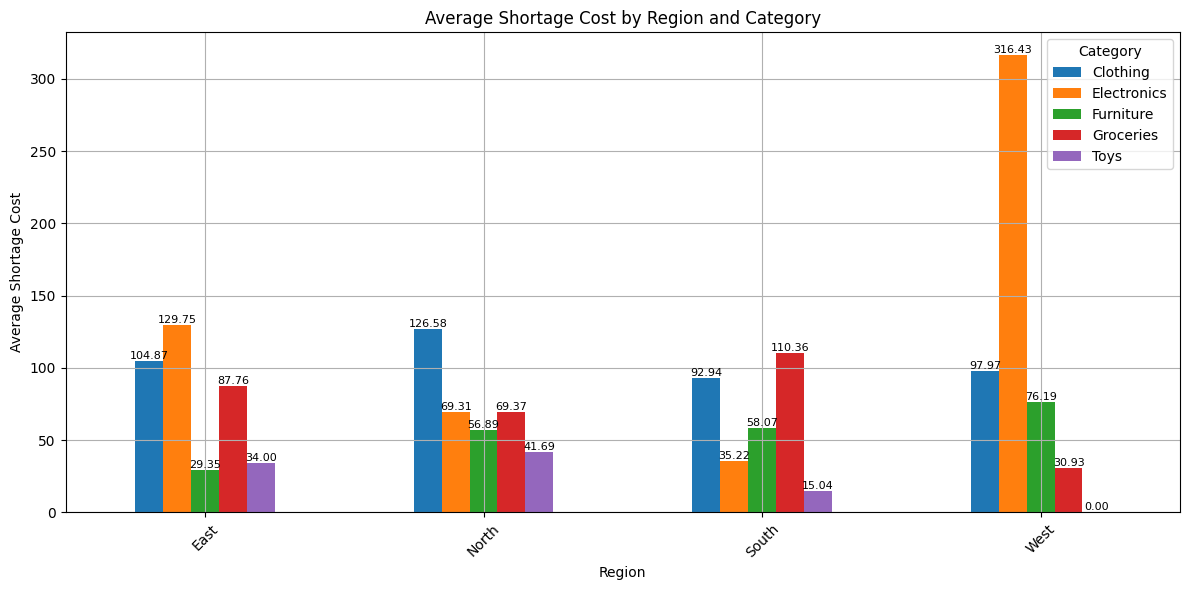

In [58]:
# Step 1: Group by Region and Category
grouped = cost_df.groupby(['Original_Region', 'Original_Category'])[['Holding_Cost', 'Shortage_Cost']].mean().reset_index()

# Step 2: Pivot to get Region as index and Category as columns
pivot_holding = grouped.pivot(index='Original_Region', columns='Original_Category', values='Holding_Cost')
pivot_shortage = grouped.pivot(index='Original_Region', columns='Original_Category', values='Shortage_Cost')

ax = pivot_holding.plot(kind='bar', figsize=(12, 6))
plt.title('Average Holding Cost by Region and Category')
plt.ylabel('Average Holding Cost')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Category')
# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8, label_type='edge')
plt.tight_layout()
plt.show()

ax = pivot_shortage.plot(kind='bar', figsize=(12, 6))
plt.title('Average Shortage Cost by Region and Category')
plt.ylabel('Average Shortage Cost')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Category')
# Add labels to each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8, label_type='edge')
plt.tight_layout()
plt.show()

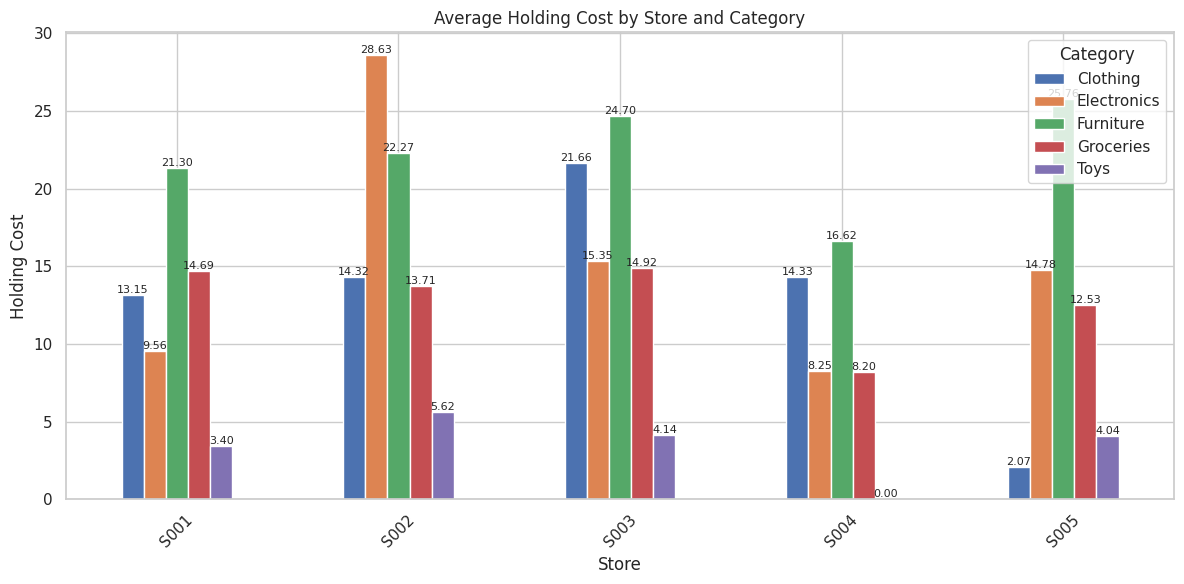

In [66]:
# Extract Store ID
cost_df['Store_ID'] = cost_df['Store_Product_ID'].str.extract(r'(S\d+)')

store_category_summary = cost_df.groupby(['Store_ID', 'Original_Category'])[['Holding_Cost', 'Shortage_Cost']].mean().reset_index().sort_values(by='Store_ID')

# Pivot for visualization
pivot_store_category = store_category_summary.pivot(index='Store_ID', columns='Original_Category', values='Holding_Cost')
ax = pivot_store_category.plot(kind='bar', figsize=(12, 6))
plt.title('Average Holding Cost by Store and Category')
plt.ylabel('Holding Cost')
plt.xlabel('Store')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Category')

# Add labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=8, label_type='edge')

plt.tight_layout()
plt.show()


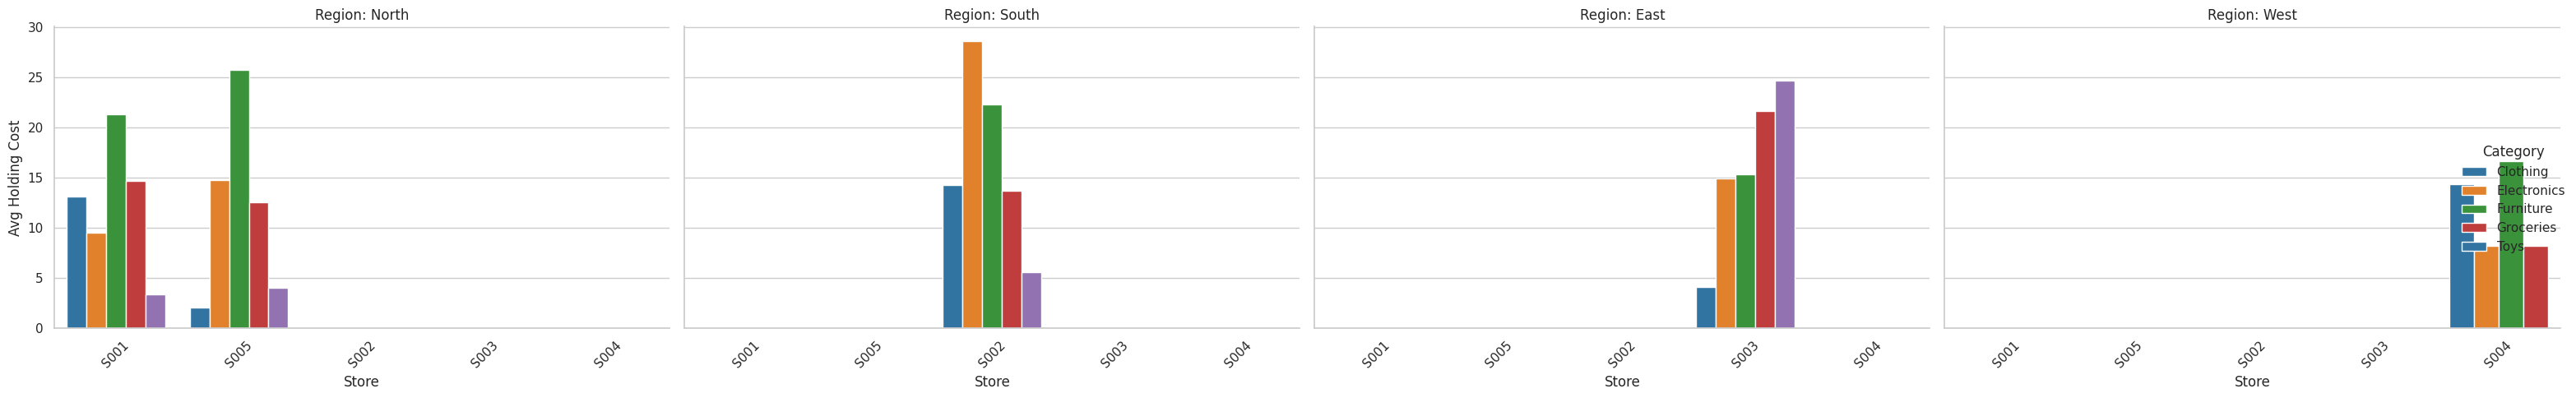

In [71]:
grouped = cost_df.groupby(['Store_ID', 'Original_Category', 'Original_Region'])[['Holding_Cost']].mean().reset_index().sort_values(by='Store_ID')

import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# Initialize FacetGrid: one plot per Region
g = sns.FacetGrid(grouped, col="Original_Region", height=5, aspect=1.5, sharey=True)

# Use barplot in each facet
g.map_dataframe(
    sns.barplot,
    x="Store_ID",
    y="Holding_Cost",
    hue="Original_Category",
    palette="tab10",
    dodge=True
)

# Adjust the aesthetics
g.set_titles(col_template="Region: {col_name}")
g.set_axis_labels("Store", "Avg Holding Cost")
g.add_legend(title="Category")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


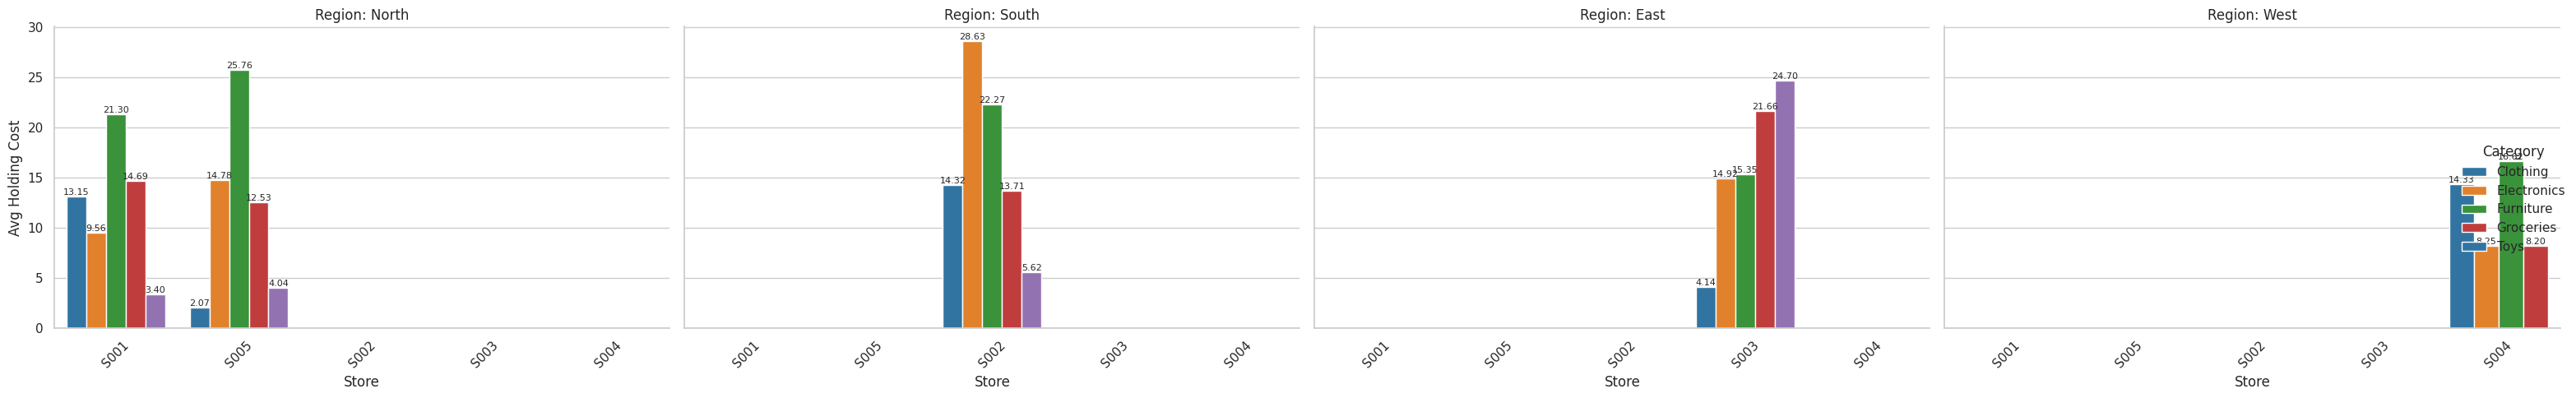

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data
grouped = cost_df.groupby(['Original_Region', 'Store_ID', 'Original_Category'])[['Holding_Cost']].mean().reset_index().sort_values(by='Store_ID')

# Initialize Seaborn
sns.set(style="whitegrid")
g = sns.FacetGrid(grouped, col="Original_Region", height=5, aspect=1.5, sharey=True)

# Plot bars
def plot_bars_with_labels(data, **kwargs):
    ax = plt.gca()
    bars = sns.barplot(
        data=data,
        x="Store_ID",
        y="Holding_Cost",
        hue="Original_Category",
        ax=ax,
        dodge=True,
        palette="tab10"
    )
    
    # Add data labels to each bar
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if not np.isnan(height):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height,
                    f'{height:.2f}',
                    ha='center',
                    va='bottom',
                    fontsize=8,
                    rotation=0
                )

# Map the function to FacetGrid
g.map_dataframe(plot_bars_with_labels)

# Titles and layout
g.set_titles(col_template="Region: {col_name}")
g.set_axis_labels("Store", "Avg Holding Cost")
g.add_legend(title="Category")

# Rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()


# 📦 Service Level (Fill Rate) in Inventory Management

## ✅ Definition

**Service Level**, in the context of inventory management, refers to the ability to meet customer demand from available inventory without incurring stockouts.

There are different types of service levels, but the one most commonly used in retail forecasting and supply chain models is the **Type 1 Service Level**, also known as the **Fill Rate**.

---

## 📘 Formula

$$
\text{Service Level} = \frac{\min(\text{Inventory Level}, \text{Predicted Demand})}{\text{Predicted Demand}}
$$

This formula estimates the fraction of predicted demand that can be met directly from available inventory — assuming no backorders are allowed.

---

## 🎓 Academic References

### 1. Simchi-Levi et al. (2008)

> *"The proportion of demand that is met directly from stock on hand without backorders is referred to as the fill rate or Type 1 service level."*

**Citation**:  
Simchi-Levi, D., Kaminsky, P., & Simchi-Levi, E. (2008). *Designing and Managing the Supply Chain: Concepts, Strategies, and Case Studies* (3rd ed.). McGraw-Hill Education.

---

### 2. Silver, Pyke, and Thomas (2016)

> *"The service level is often defined as the probability that demand during the lead time will not exceed inventory (Type 2), or as the fraction of demand that can be filled immediately (Type 1 or fill rate)."*

**Citation**:  
Silver, E. A., Pyke, D. F., & Thomas, D. J. (2016). *Inventory and Production Management in Supply Chains* (4th ed.). CRC Press.

---

## 🧠 When to Use This Formula

This fill-rate formula is appropriate when:
- You are using **predicted demand** (e.g., from machine learning)
- You want a **forward-looking metric**
- You need to estimate **how well your inventory policy covers demand**
- Backorders are **not modeled explicitly**

In [75]:
# Prevent division by zero
cost_df['Predicted_Demand'] = cost_df['y_pred'].clip(lower=1e-6)

# Calculate Fill Rate (Service Level)
cost_df['Service_Level'] = (
    cost_df[['Inventory Level', 'Predicted_Demand']].min(axis=1)
    / cost_df['Predicted_Demand']
).clip(upper=1.0)

service_summary = cost_df.groupby(['Store_ID', 'Original_Category'])['Service_Level'].mean().reset_index()


Group by Store + Category

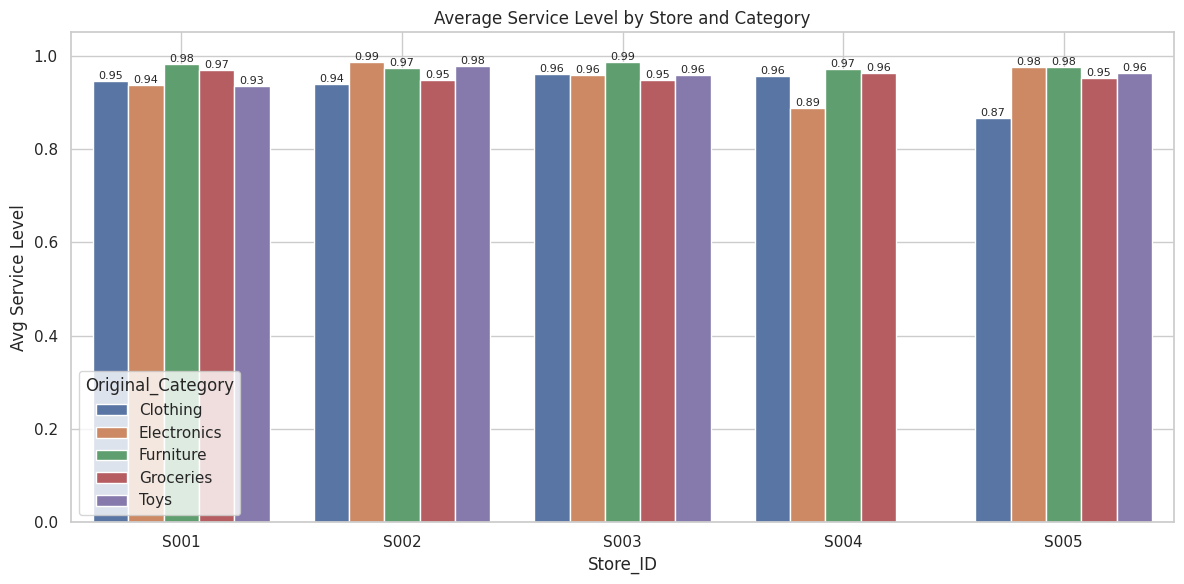

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=service_summary, x='Store_ID', y='Service_Level', hue='Original_Category')
plt.title('Average Service Level by Store and Category')
plt.ylabel('Avg Service Level')
plt.ylim(0, 1.05)
plt.grid(True)

# Add values
for c in plt.gca().containers:
    plt.bar_label(c, fmt='%.2f', fontsize=8)

plt.tight_layout()
plt.show()


Group by Region + Store + Category

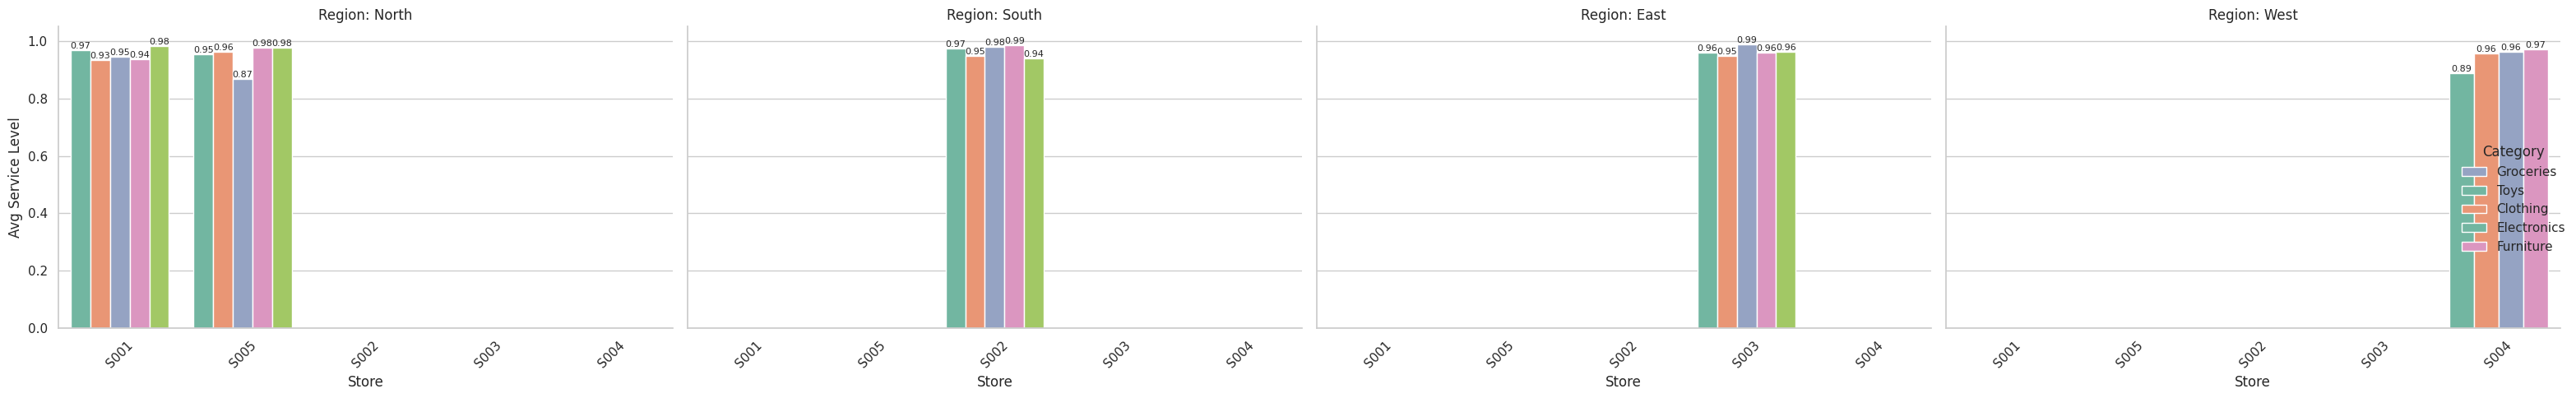

In [79]:
service_df = cost_df.groupby(['Original_Region', 'Store_ID', 'Original_Category'])['Service_Level'].mean().reset_index().sort_values(by='Store_ID')

g = sns.FacetGrid(service_df, col='Original_Region', height=5, aspect=1.5)
g.map_dataframe(sns.barplot, x='Store_ID', y='Service_Level', hue='Original_Category', palette='Set2')

for ax in g.axes.flat:
    ax.set_ylim(0, 1.05)
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height:.2f}',
                ha='center',
                va='bottom',
                fontsize=8
            )

g.set_titles("Region: {col_name}")
g.set_axis_labels("Store", "Avg Service Level")
g.add_legend(title="Category")
plt.tight_layout()
plt.show()
